In [1]:
# 1. Cài các thư viện (Dùng bản GPU cho Paddle)
!pip install ultralytics paddlepaddle-gpu paddleocr==2.7.3

# 2. [QUAN TRỌNG] Hạ cấp Numpy để tránh lỗi xung đột
!pip install "numpy<2.0.0"

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
# Giải nén lại model
!tar -xvf /content/yolov11-lp-nano-other-default-v1.tar.gz

kaggle/working/
kaggle/
kaggle/working/data.yaml
kaggle/working/runs/segment/predict/
kaggle/working/runs/segment/
kaggle/working/runs/
kaggle/working/runs/segment/predict/Tgmt_0050.jpg
kaggle/working/runs/segment/val/
kaggle/working/runs/segment/val/BoxF1_curve.png
kaggle/working/runs/segment/val/BoxPR_curve.png
kaggle/working/runs/segment/val/BoxP_curve.png
kaggle/working/runs/segment/val/BoxR_curve.png
kaggle/working/runs/segment/val/MaskF1_curve.png
kaggle/working/runs/segment/val/MaskPR_curve.png
kaggle/working/runs/segment/val/MaskP_curve.png
kaggle/working/runs/segment/val/MaskR_curve.png
kaggle/working/runs/segment/val/confusion_matrix.png
kaggle/working/runs/segment/val/confusion_matrix_normalized.png
kaggle/working/runs/segment/val/val_batch0_labels.jpg
kaggle/working/runs/segment/val/val_batch0_pred.jpg
kaggle/working/runs/segment/val/val_batch1_labels.jpg
kaggle/working/runs/segment/val/val_batch1_pred.jpg
kaggle/working/runs/segment/val/val_batch2_labels.jpg
kaggle/working

>>> Đang khởi tạo hệ thống...
    - YOLO: Chạy trên GPU (Siêu nhanh)
    - OCR:  Chạy trên CPU (Ổn định, tránh sập nguồn)

0: 416x640 1 LpV, 59.9ms
Speed: 3.3ms preprocess, 59.9ms inference, 20.5ms postprocess per image at shape (1, 3, 416, 640)

>>> Tìm thấy 1 biển số.
✅ KẾT QUẢ XE 1: 90B245230


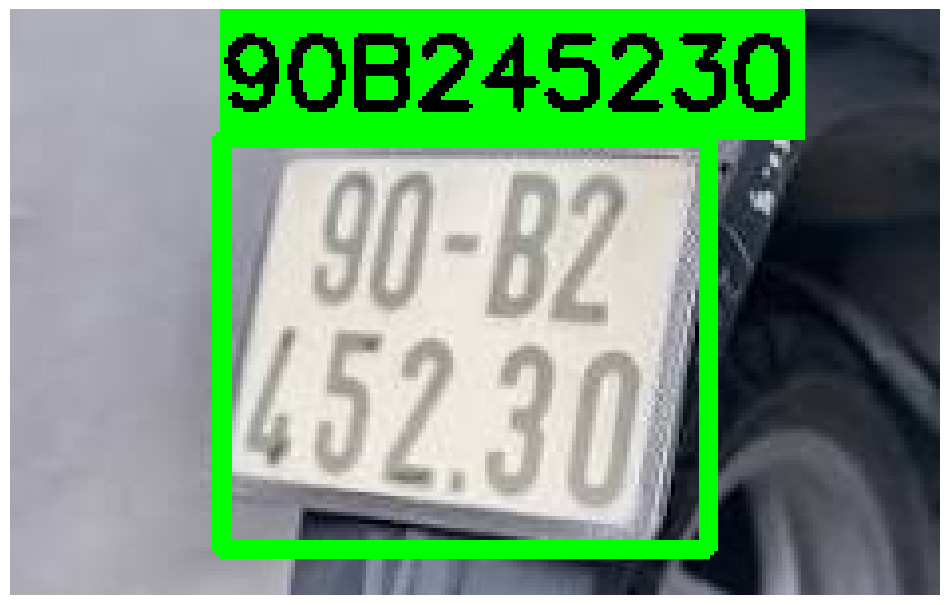

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from paddleocr import PaddleOCR
import os
import re

# --- CẤU HÌNH ---
YOLO_PATH = '/content/kaggle/working/runs/segment/yolo11_license_plate/weights/best.pt'
IMAGE_PATH = 'test1.jpg'

def clean_text(text):
    return re.sub(r'[^A-Za-z0-9]', '', text).upper()

def process_results(ocr_result):
    if ocr_result is None: return ""
    sorted_res = sorted(ocr_result, key=lambda x: x[0][0][1])
    final_text = ""
    for line in sorted_res:
        text, conf = line[1]
        if conf > 0.6:
            final_text += text
    return clean_text(final_text)

if not os.path.exists(YOLO_PATH):
    print("❌ LỖI: Chưa thấy file model.")
elif not os.path.exists(IMAGE_PATH):
    print("❌ LỖI: Chưa thấy file ảnh test1.jpg.")
else:
    print(">>> Đang khởi tạo hệ thống...")
    print("    - YOLO: Chạy trên GPU (Siêu nhanh)")
    print("    - OCR:  Chạy trên CPU (Ổn định, tránh sập nguồn)")

    # 1. Load YOLO (Nó tự động nhận GPU T4 của Colab)
    yolo = YOLO(YOLO_PATH)

    # 2. Load PaddleOCR (QUAN TRỌNG: Chuyển use_gpu=False)
    # Lý do: Để tránh xung đột CUDA với YOLO, và OCR ảnh nhỏ trên CPU vẫn rất nhanh.
    ocr = PaddleOCR(use_angle_cls=True, lang='en', show_log=False, use_gpu=False)

    # 3. Đọc ảnh
    img = cv2.imread(IMAGE_PATH)

    # 4. Detect (YOLO chạy trên GPU)
    results = yolo(img)[0]
    print(f"\n>>> Tìm thấy {len(results.boxes)} biển số.")

    # 5. Xử lý
    for i, box in enumerate(results.boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        h, w, _ = img.shape
        crop = img[max(0, y1-5):min(h, y2+5), max(0, x1-5):min(w, x2+5)]

        # Nhận diện (OCR chạy trên CPU)
        result = ocr.ocr(crop, cls=True)

        if result and result[0]:
            plate_text = process_results(result[0])
            print(f"✅ KẾT QUẢ XE {i+1}: {plate_text}")

            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
            (w_text, h_text), _ = cv2.getTextSize(plate_text, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
            cv2.rectangle(img, (x1, y1 - 35), (x1 + w_text, y1), (0, 255, 0), -1)
            cv2.putText(img, plate_text, (x1, y1 - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
        else:
            print(f"⚠️ XE {i+1}: Không đọc được.")

    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()